# **Customer Segmentation: TheLook e-commerce data**
## Amber Walker

In this notebook, we will explore customer segmentation using two popular clustering methods: Gaussian Mixture Model (GMM) and K-Means. We're looking at Google BigQuery's dataset, TheLook, an e-commerce clothing store developed by the Google Looker team.

TheLook dataset contains rich customer and transactional data, which provides an excellent opportunity to perform clustering for customer segmentation. This segmentation helps in identifying distinct customer groups based on their purchase behavior, such as frequency, recency, and monetary value. The insights from this analysis can guide marketing strategies, improve customer targeting, and enhance overall business performance.

I used DBT (Data Build Tool) to transform the data for easier analysis and model building.

Key Objectives:

- Compare the performance of Gaussian Mixture Model and K-Means clustering methods.
- Identify meaningful customer segments based on their purchase behaviors.
- Provide actionable insights for marketing campaigns and business strategy.
- By the end of this notebook, we aim to evaluate the quality of clustering using performance metrics (e.g., Silhouette Score) and visualize customer segments in a way that is intuitive and actionable for business decision-makers.

# **Table of Contents**

0. **[Part 0: Setup and Import](#part0)**  
   - **Objective**: Initialize the programming environment and import the dataset.  
   - **Tasks:**  
     - Import necessary libraries.  
     - Connect to Google BigQuery and load transformed **TheLook** dataset.  
     - Perform an initial exploration of the dataset (e.g., missing values, data types, summary statistics).  

1. **[Part 1: Feature Engineering](#part1)**  
   - **Objective**: Create key features for customer segmentation.  
   - **Tasks:**  
     - Derive **Recency**, **Frequency**, and **Monetary (RFM)** variables.  
     - Standardize the RFM variables to prepare for clustering.  

2. **[Part 2: Clustering Methods](#part2)**  
   - **Objective**: Apply clustering methods to segment customers.  
   - **Tasks:**  
     - Use the **Elbow Method** to determine the optimal number of clusters for K-Means.  
     - Perform clustering using **K-Means** with the optimal number of clusters.  
     - Perform clustering using the **Gaussian Mixture Model (GMM)** with the same number of clusters.  
     - Assign cluster labels to the dataset for both methods.  

3. **[Part 3: Cluster Evaluation](#part3)**  
   - **Objective**: Evaluate the quality of the clustering methods.  
   - **Tasks:**  
     - Calculate the **Silhouette Score** for both K-Means and GMM.  
     - Compare the performance of K-Means and GMM using evaluation metrics.  
     - Visualize clusters in a 3D space using **Principal Component Analysis (PCA)**.  

4. **[Part 4: Cluster Analysis](#part4)**  
   - **Objective**: Interpret the characteristics of each customer cluster.  
   - **Tasks:**  
     - Aggregate key metrics (e.g., recency, frequency, monetary) for each cluster.  
     - Analyze cluster-specific patterns and behaviors (e.g., high spenders, infrequent buyers).  
     - Identify actionable insights for marketing and business strategies.  


## **0. Part 0: Setup and Import** <a id="part0"></a>
### **Objective**
Initialize the programming environment and load the dataset.

### **Tasks**
1. Import necessary libraries.
2. Connect to Google BigQuery and load transformed **TheLook** dataset.
3. Explore the dataset.

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from itertools import combinations
import os
import config
from sklearn.preprocessing import PowerTransformer
from yellowbrick.cluster import KElbowVisualizer
from google.cloud import bigquery
from mpl_toolkits.mplot3d import Axes3D

data_path = "/Users/amber/projects/my_customer_segmentation_project_mlm/ml-model/data/"


In [41]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.path_to_key
client = bigquery.Client()

project_id = config.project_id
table_id = config.table_id

In [42]:
table = client.get_table(table_id) 
df = client.list_rows(table).to_dataframe()

print(df.head())

c:\Users\amber\projects\my_customer_segmentation_project_mlm\ml-model\venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   customer_id  customer_tenure  recency  total_orders_completed  \
0        75990              457      844                       1   
1        77936                1      307                       1   
2        86560                1     1595                       2   
3         5671              360      164                       1   
4         4628                1     1667                       1   

   total_sales_completed  total_sales  total_orders  returned_orders_ratio  \
0              19.990000    19.990000             1                    0.0   
1              27.990000    27.990000             1                    0.0   
2             108.200001   108.200001             1                    0.0   
3              59.990002   104.980003             2                    0.0   
4             195.300003   195.300003             1                    0.0   

   cancelled_orders_ratio  customer_age  ... accessories outerwear shorts  \
0                     0.0            35  ... 

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27575 entries, 0 to 27574
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             27575 non-null  Int64  
 1   customer_tenure         27575 non-null  Int64  
 2   recency                 27575 non-null  Int64  
 3   total_orders_completed  27575 non-null  Int64  
 4   total_sales_completed   27575 non-null  float64
 5   total_sales             27575 non-null  float64
 6   total_orders            27575 non-null  Int64  
 7   returned_orders_ratio   27575 non-null  float64
 8   cancelled_orders_ratio  27575 non-null  float64
 9   customer_age            27575 non-null  Int64  
 10  customer_gender         27575 non-null  object 
 11  state                   27575 non-null  object 
 12  city                    27575 non-null  object 
 13  country                 27575 non-null  object 
 14  total_cancels           22100 non-null

In [44]:
df.isna().sum()

customer_id                  0
customer_tenure              0
recency                      0
total_orders_completed       0
total_sales_completed        0
total_sales                  0
total_orders                 0
returned_orders_ratio        0
cancelled_orders_ratio       0
customer_age                 0
customer_gender              0
state                        0
city                         0
country                      0
total_cancels             5475
total_cart                5475
total_department          5475
total_home                5475
total_product             5475
total_purchases           5475
tops_and_tees                0
jeans                        0
intimates                    0
swim                         0
sweaters                     0
sleep                        0
accessories                  0
outerwear                    0
shorts                       0
fasion_hoodies               0
active                       0
underwear                    0
pants   

There are missing valuse for the category proportions and city, even though we are not using them for our customer segmentation analysis, we will still be looking at them later in Tableau, so we will set the web activity nulls to 0 (since the nulls probably just mean they did not perform those actions). And for the city values, we will actually just leave those as missing for now.

In [47]:
##fill missing values with zero, these customers most likely bought in store
columns_to_fill = ['total_cancels', 'total_cart', 'total_department', 'total_home', 'total_product', 'total_purchases']
for col in columns_to_fill:
    df[col] = df[col].fillna(0)
df.isna().sum()

customer_id               0
customer_tenure           0
recency                   0
total_orders_completed    0
total_sales_completed     0
total_sales               0
total_orders              0
returned_orders_ratio     0
cancelled_orders_ratio    0
customer_age              0
customer_gender           0
state                     0
city                      0
country                   0
total_cancels             0
total_cart                0
total_department          0
total_home                0
total_product             0
total_purchases           0
tops_and_tees             0
jeans                     0
intimates                 0
swim                      0
sweaters                  0
sleep                     0
accessories               0
outerwear                 0
shorts                    0
fasion_hoodies            0
active                    0
underwear                 0
pants                     0
socks                     0
dresses                   0
other               

In [48]:
df.columns

Index(['customer_id', 'customer_tenure', 'recency', 'total_orders_completed',
       'total_sales_completed', 'total_sales', 'total_orders',
       'returned_orders_ratio', 'cancelled_orders_ratio', 'customer_age',
       'customer_gender', 'state', 'city', 'country', 'total_cancels',
       'total_cart', 'total_department', 'total_home', 'total_product',
       'total_purchases', 'tops_and_tees', 'jeans', 'intimates', 'swim',
       'sweaters', 'sleep', 'accessories', 'outerwear', 'shorts',
       'fasion_hoodies', 'active', 'underwear', 'pants', 'socks', 'dresses',
       'other'],
      dtype='object')

In [49]:
df['country'].unique()

array(['Brasil', 'United States', 'Japan', 'China', 'South Korea',
       'Spain', 'France', 'United Kingdom', 'Germany', 'Colombia',
       'Belgium', 'Poland', 'Australia', 'Deutschland'], dtype=object)

## **1. Part 1: Feature Engineering** <a id="part1"></a>
### **Objective**
Create key features for customer segmentation.

### **Tasks**
1. Derive Recency, Frequency, and Monetary (RFM) variables.
2. Standardize the RFM variables.

### Derive FRM Features
RFM is highly useful for clustering because it helps identify patterns in customer behavior, allowing businesses to group customers into meaningful segments such as high-value customers, loyal customers, or inactive customers. By focusing on these features, businesses can better tailor their marketing strategies, improve customer retention, and maximize profitability through targeted engagement.

In [50]:
df.rename(columns={'total_sales_completed': 'monetary', 'total_orders': 'frequency'}, inplace=True)
df.head()

,customer_id,customer_tenure,recency,total_orders_completed,monetary,total_sales,frequency,returned_orders_ratio,cancelled_orders_ratio,customer_age,...,accessories,outerwear,shorts,fasion_hoodies,active,underwear,pants,socks,dresses,other
0,75990,457,844,1,19.990000,19.990000,1,0.0,0.0,35,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,77936,1,307,1,27.990000,27.990000,1,0.0,0.0,49,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
2,86560,1,1595,2,108.200001,108.200001,1,0.0,0.0,46,...,0.0,0.0,0.0,0.0,0.399261,0.0,0.0,0.0,0.0,0.0
3,5671,360,164,1,59.990002,104.980003,2,0.0,0.5,21,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,4628,1,1667,1,195.300003,195.300003,1,0.0,0.0,61,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [51]:
features = [
    'frequency', 'monetary', 'recency'
]

rfm = df[features]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **2. Part 2: Clustering Methods** <a id="part2"></a>
### **Objective**
Apply clustering methods to segment customers.

### **Tasks**
1. Use the Elbow Method to determine the optimal number of clusters for K-Means.
2. Perform clustering using K-Means.
3. Perform clustering using Gaussian Mixture Model (GMM).

### Elbow Method
The Elbow Method is a technique used to determine the optimal number of clusters for clustering algorithms like K-Means. It evaluates the distortion score (within-cluster sum of squared distances) for different numbers of clusters and plots them. The "elbow" point, where the distortion score decreases significantly less, indicates the ideal number of clusters. This method helps balance cluster accuracy and simplicity, ensuring that the chosen number of clusters is neither too few nor too many.

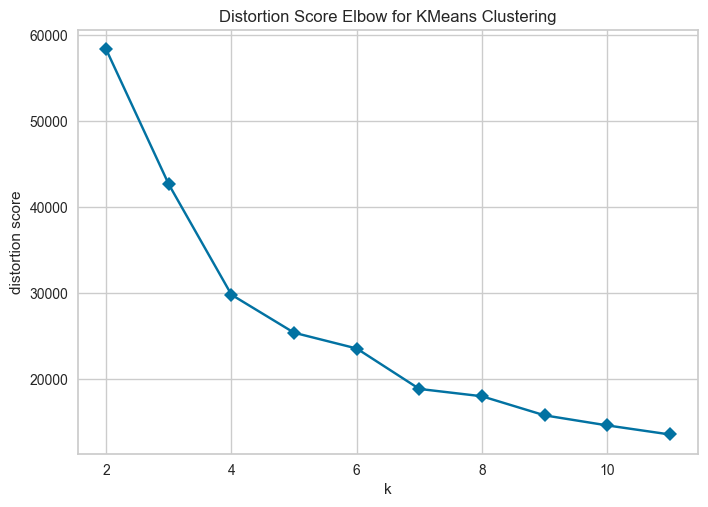

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, locate_elbow=False)
visualizer.fit(X_scaled)  
visualizer.show()

### K-Means Clustering
K-Means partitions data points into 𝑘 clusters. It works by minimizing the within-cluster sum of squared distances between data points and their respective cluster centroids. K-Means is efficient, scalable, and widely used for segmentation tasks like customer profiling, as it groups data points with similar characteristics into distinct clusters. The problem is though that it assumes spherical clusters and can struggle with non-linear or overlapping data (that's where GMM comes in).

In [53]:
kmeans =KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
df['cluster_kmeans'] = kmeans.labels_

### GMM Clustering
The Gaussian Mixture Model (GMM) is a probabilistic clustering method that assumes the data is generated from a mixture of Gaussian distributions. Unlike K-Means, which assigns each point to a single cluster, GMM calculates the probability of each data point belonging to multiple clusters, making it more flexible for handling overlapping clusters. GMM is particularly useful when data points exhibit a natural probabilistic distribution or when clusters vary in shape and size (they assume a Gaussian distribution rather than spherical clusters).

In [54]:
optimal_n = 4
gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=421)
gmm.fit(X_scaled)

df['cluster_gmm'] = gmm.predict(X_scaled)

## **3. Part 3: Cluster Evaluation** <a id="part3"></a>
### **Objective**
Evaluate the quality of the clustering methods.

### **Tasks**
1. Calculate the Silhouette Score for both K-Means and GMM.
2. Visualize clusters in a 3D space using PCA.

### Silhouette Score
The Silhouette Score is a metric used to evaluate the quality of a clustering result. It measures how similar a data point is to its own cluster compared to other clusters. The score ranges from −1 to 1:

- A score close to 1 indicates well-separated and dense clusters.
- A score close to 0 suggests overlapping clusters.
- Negative scores imply that data points may be assigned to the wrong cluster.

The Silhouette Score is really goof for comparing different clustering algorithms or configurations to ensure that clusters are meaningful and well-defined.

In [55]:
# Evaluate K-Means
kmeans_score = silhouette_score(X_scaled, df['cluster_kmeans'])
print(f"K-Means Silhouette Score: {kmeans_score}")

# Evaluate GMM
gmm_score = silhouette_score(X_scaled, df['cluster_gmm'])
print(f"GMM Silhouette Score: {gmm_score}")

K-Means Silhouette Score: 0.43721666408512627
GMM Silhouette Score: 0.3306274283613274


The K-Means Silhouette Score (0.44) indicates a moderate clustering quality, suggesting that the clusters are relatively well-separated and dense. On the other hand, the Gaussian Mixture Model (GMM) Silhouette Score (0.33) is lower, implying that the clusters are less distinct and may have significant overlap. Based on these scores, K-Means appears to be the better-performing clustering method for this dataset.

### 3D PCA Visualization
3D PCA Visualization leverages Principal Component Analysis (PCA), a dimensionality reduction technique, to project high-dimensional data into three principal components for visualization. It captures the most important patterns in the data while preserving as much variability as possible. When applied to clustering, 3D PCA helps us to visualize the structure of clusters and their separation in a simplified space, making it easier to interpret and evaluate clustering results.

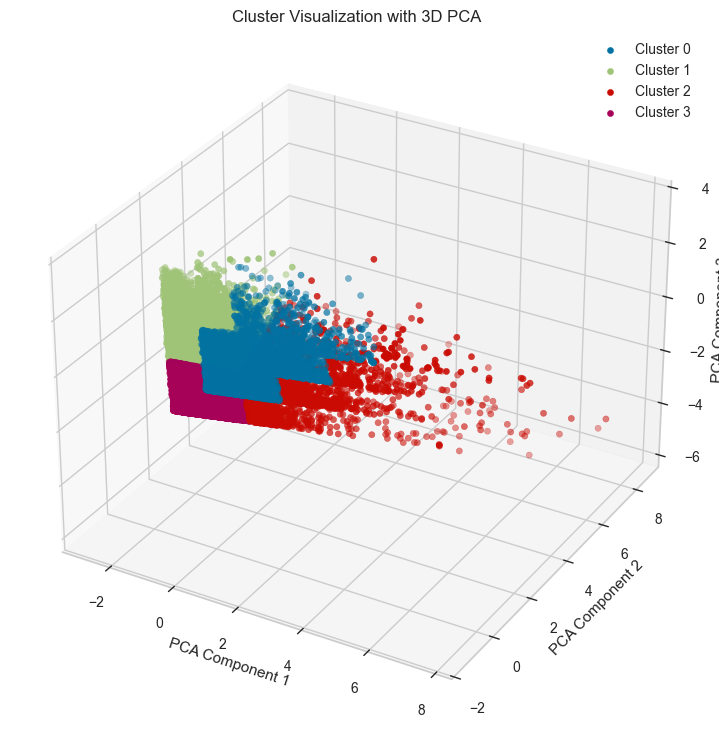

In [56]:
#pca for kmeans
clusters = df['cluster_kmeans'].values
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
for cluster in set(clusters):
    ax.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        X_pca[clusters == cluster, 2],
        label=f'Cluster {cluster}'
    )
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Cluster Visualization with 3D PCA')
plt.legend()
plt.show()

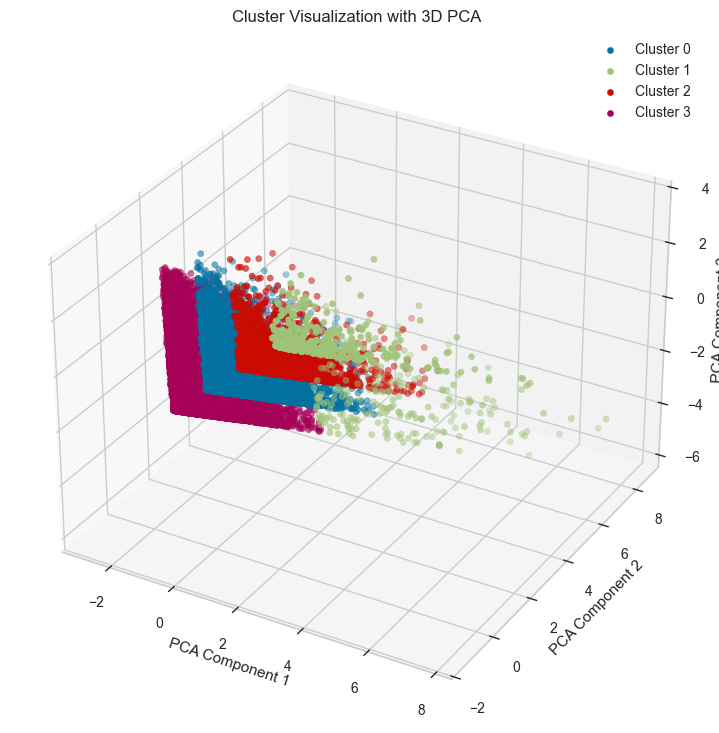

In [57]:
#pca for GMM
clusters = df['cluster_gmm'].values
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
for cluster in set(clusters):
    ax.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        X_pca[clusters == cluster, 2],
        label=f'Cluster {cluster}'
    )
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Cluster Visualization with 3D PCA')
plt.legend()
plt.show()



## **4. Part 4: Cluster Analysis** <a id="part4"></a>
### **Objective**
Interpret the characteristics of each customer cluster.

### **Tasks**
1. Aggregate key metrics (e.g., recency, frequency, monetary) for each cluster.
2. Identify actionable insights for marketing and business strategies.

In [58]:
df.groupby('cluster_kmeans').agg({'recency':'mean',
                                  'frequency':'mean',
                                  'monetary':['mean','count'],
                                  'returned_orders_ratio': 'mean'}).round(2)

recency frequency monetary        returned_orders_ratio
                   mean      mean     mean  count                  mean
cluster_kmeans                                                         
0                 263.7      2.29    91.27   7011                  0.21
1               1179.39      1.09    75.06   6093                  0.02
2                388.81      1.67   384.00   1876                  0.06
3                269.44       1.0    70.40  12595                  0.00

### Cluster Classifications
#### Cluster 2: "Platinum Customers" High-Value Shoppers
- They spend the most (monetary = 384.00).
- They are moderately active (recency = 388.81 days, frequency = 1.67).
- They have a low return rate (0.06), indicating satisfaction.
##### Strategy:
These are the most valuable customers. We could offer exclusive benefits such as VIP programs, early access to new products, or personalized recommendations to retain their loyalty.

#### Cluster 0: "Gold Customers" Loyal Mid-Spenders
- Moderate spenders (monetary = 91.27).
- Relatively frequent buyers (frequency = 2.29).
- Recent purchases (recency = 263.7 days).
- Higher return rate (0.21), which may indicate dissatisfaction.
##### Strategy:
We might focus on reducing the return rate by improving product descriptions, sizing guides, or offering easy exchanges. Provide loyalty rewards to encourage repeat purchases.

#### Cluster 3: "Silver Customers" Infrequent Low-Spenders
- Spend the least (monetary = 70.40).
- Minimal engagement (frequency = 1.0).
Recent purchases (recency = 269.44 days).
- No returns (0.00), suggesting low engagement rather than dissatisfaction.
##### Strategy:
We may want to encourage repeat purchases with targeted discounts about items they previously purchased or browsed.

#### Cluster 1: "Bronze Customers" Dormant Low-Spenders
- Minimal spenders (monetary = 75.06).
- Lowest engagement (frequency = 1.09, recency = 1179.39 days).
- Low return rate (0.02), but primarily inactive.
##### Strategy:
We would want to re-engage these dormant customers with win-back campaigns, personalized offers, or surveys to understand why they are no longer active.


In [59]:
df.to_csv(data_path + 'data_w_clusters.csv', index=False)